In [1]:
from os.path import abspath

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.ml.feature import VectorAssembler

import datetime
import os

pyspark_submit_args = "--driver-memory 4g "
pyspark_submit_args += "--executor-memory 4g "
pyspark_submit_args += "pyspark-shell"
os.environ['PYSPARK_SUBMIT_ARGS'] = pyspark_submit_args

#warehouse_location = abspath('spark-warehouse')
#spark = SparkSession.builder.config("spark.sql.warehouse.dir", warehouse_location).appName("SparkSQL").getOrCreate()
spark = SparkSession.builder.getOrCreate()

In [2]:
def log2row(line):    
    fields = line.split(',')
    row_eid = int(fields[0])
    row_source = fields[2]
    row_event = fields[3]
    row_object = fields[4]
    t = fields[1].split('T')
    r_date = t[0].split('-')
    r_time = t[1].split(':')
    row_date = datetime.datetime(int(r_date[0]), int(r_date[1]), int(r_date[2]), 0, 0, 0)
    row_time = datetime.datetime(1990, 1, 1, int(r_time[0]), int(r_time[1]), int(r_time[2]))
    return Row(enrollment_id = row_eid, date = row_date, time = row_time, source = row_source, event = row_event, object_id = row_object )


def true2row(line):
    fields = line.split(',')
    row_eid = int(fields[0])
    row_dropout = bool(int(fields[1]))
    return Row(enrollment_id = row_eid, dropout = row_dropout)
        

def date2row(line):
    fields = line.split(',')
    row_cid = fields[0]
    r_from = fields[1].split('-')
    r_to = fields[2].split('-')
    row_from = datetime.datetime(int(r_from[0]), int(r_from[1]), int(r_from[2]), 0, 0, 0)
    row_to = datetime.datetime(int(r_to[0]), int(r_to[1]), int(r_to[2]), 0, 0, 0)    
    return Row(course_id = row_cid, fromdate = row_from, todate = row_to) 

def enrollment2row(line):
    fields = line.split(',')
    row_eid = int(fields[0])
    row_username = fields[1]
    row_cid = fields[2]
    return Row(enrollment_id = row_eid, username = row_username, course_id = row_cid)
  
    
def object2row(line):
    fields = line.split(',')
    if len(fields) == 5:    
        row_cid = fields[0]
        row_mid = fields[1]
        row_category = fields[2]
        row_children = fields[3]
        row_date = datetime.datetime(1990, 1, 1, 0, 0, 0)
        row_time = datetime.datetime(1990, 1, 1, 0, 0, 0)
        if fields[4] != "null":
            t = fields[4].split('T')
            r_date = t[0].split('-')
            r_time = t[1].split(':')
            row_date = datetime.datetime(int(r_date[0]), int(r_date[1]), int(r_date[2]), 0, 0, 0)
            row_time = datetime.datetime(1990, 1, 1, int(r_time[0]), int(r_time[1]), int(r_time[2]))
        return Row(course_id = row_cid, module_id = row_mid, category = row_category, children=row_children, date=row_date, time=row_time)
    elif len(fields) == 4:
        row_cid = fields[0]
        row_mid = fields[1]
        row_category = fields[2]
        row_children = ""        
        row_date = datetime.datetime(1990, 1, 1, 0, 0, 0)
        row_time = datetime.datetime(1990, 1, 1, 0, 0, 0)
        if fields[3] != "null":
            t = fields[3].split('T')
            r_date = t[0].split('-')
            r_time = t[1].split(':')
            row_date = datetime.datetime(int(r_date[0]), int(r_date[1]), int(r_date[2]), 0, 0, 0)
            row_time = datetime.datetime(1990, 1, 1, int(r_time[0]), int(r_time[1]), int(r_time[2]))
        return Row(course_id = row_cid, module_id = row_mid, category = row_category, children=row_children, date=row_date, time=row_time)    


In [6]:
#Convert each csv file to RDD
#Parse each line using function defined above
#Convert parsed RDD to DataFrame and create temp views
log_table = spark.sparkContext.textFile("Data/log.csv")
log_head = log_table.first()
log_table_no_header = log_table.filter(lambda x : x != log_head)


true_table = spark.sparkContext.textFile("Data/truth_train.csv")
true_head = true_table.first()
true_table_no_header = true_table.filter(lambda x : x != true_head)


date_table = spark.sparkContext.textFile("Data/date.csv")
date_head = date_table.first()
date_table_no_header = date_table.filter(lambda x : x != date_head)


enrollment_table = spark.sparkContext.textFile("Data/enrollment.csv")
enrollment_head = enrollment_table.first()
enrollment_table_no_header = enrollment_table.filter(lambda x : x != enrollment_head)

object_table = spark.sparkContext.textFile("Data/object.csv")
object_head = object_table.first()
object_table_no_header = object_table.filter(lambda x : x != object_head)


In [7]:

log_rows = log_table_no_header.map(log2row)
true_rows = true_table_no_header.map(true2row)
date_rows = date_table_no_header.map(date2row)
enrollment_rows = enrollment_table_no_header.map(enrollment2row)
object_rows = object_table_no_header.map(object2row)


In [8]:

log_df = spark.createDataFrame(log_rows)
log_df.createOrReplaceTempView("log_t")

true_df = spark.createDataFrame(true_rows)
true_df.createOrReplaceTempView("true_t")

date_df = spark.createDataFrame(date_rows)
date_df.createOrReplaceTempView("date_t")

enrollment_df = spark.createDataFrame(enrollment_rows)
enrollment_df.createOrReplaceTempView("enrollment_t")

object_df = spark.createDataFrame(object_rows)
object_df.createOrReplaceTempView("object_t")


In [10]:
log_df.show(3)
log_df.printSchema()
true_df.show(3)
date_df.show(3)
enrollment_df.show(3)
object_df.show(3)

+-------------------+-------------+--------+--------------------+------+-------------------+
|               date|enrollment_id|   event|           object_id|source|               time|
+-------------------+-------------+--------+--------------------+------+-------------------+
|2014-06-14 00:00:00|            1|navigate|Oj6eQgzrdqBMlaCta...|server|1990-01-01 09:38:29|
|2014-06-14 00:00:00|            1|  access|3T6XwoiMKgol57cm2...|server|1990-01-01 09:38:39|
|2014-06-14 00:00:00|            1|  access|qxvBNYTfiRkNcCvM0...|server|1990-01-01 09:38:39|
+-------------------+-------------+--------+--------------------+------+-------------------+
only showing top 3 rows

root
 |-- date: timestamp (nullable = true)
 |-- enrollment_id: long (nullable = true)
 |-- event: string (nullable = true)
 |-- object_id: string (nullable = true)
 |-- source: string (nullable = true)
 |-- time: timestamp (nullable = true)

+-------+-------------+
|dropout|enrollment_id|
+-------+-------------+
|  false|

In [11]:
# SQL 1
# COUNT: 7
results1 = spark.sql('''SELECT enrollment_id,
sum(CASE WHEN event = "discussion" THEN count_event ELSE 0 END) c_discusion,
sum(CASE WHEN event = "wiki" THEN count_event ELSE 0 END) c_wiki,
sum(CASE WHEN event = "page_close" THEN count_event ELSE 0 END) c_page_close,
sum(CASE WHEN event = "access" THEN count_event ELSE 0 END) c_access,
sum(CASE WHEN event = "video" THEN count_event ELSE 0 END) c_video,
sum(CASE WHEN event = "navigate" THEN count_event ELSE 0 END) c_navigate,
sum(CASE WHEN event = "problem" THEN count_event ELSE 0 END) c_problem 
FROM 
 (SELECT enrollment_id, event, count(*) as count_event
 FROM log_t 
 group by enrollment_id, event) 
 group by enrollment_id 
 order by enrollment_id ''').cache()

In [12]:
# SQL 2
# COUNT: 2, ACCUMULATE: 9
results2 = spark.sql('''SELECT enrollment_id,
sum(CASE WHEN source = "browser" THEN count_event ELSE 0 END) s_browser,
sum(CASE WHEN source = "server" THEN count_event ELSE 0 END) s_server
FROM 
 (SELECT enrollment_id,source, count(*) as count_event FROM log_t group by enrollment_id, source order by enrollment_id)
 group by enrollment_id
 order by enrollment_id
 ''').cache()
joined_results1_2 = results2.join(results1,'enrollment_id','outer').cache()

In [13]:
#####################3 & 4 & 5

# SQL 3
# COUNT: 1, ACCUMULATE: 10
results3 = spark.sql('SELECT course_id, count(enrollment_id) as count_eid_per_course FROM enrollment_t group by course_id order by course_id').cache()

# SQL 4
# COUNT: 1, ACCUMULATE: 11
results4 = spark.sql('SELECT course_id, count(e.enrollment_id) as dropout_per_course FROM enrollment_t as e, true_t as t WHERE e.enrollment_id = t.enrollment_id and t.dropout = 1 group by course_id order by course_id').cache()

results4.show(5)
# SQL 5
# COUNT: 1, ACCUMULATE: 12
results5 = spark.sql('SELECT sq1.course_id as course_id, sq2.do/sq1.ce as dropoutrate_per_course FROM (SELECT course_id, count(enrollment_id) as ce FROM enrollment_t group by course_id) as sq1,(SELECT course_id, count(dropout) as do FROM enrollment_t as e, true_t as t WHERE e.enrollment_id = t.enrollment_id and t.dropout = 1 group by course_id) as sq2 WHERE sq1.course_id = sq2.course_id order by sq1.course_id').cache()


joined_result_3_4_5 = results3.join(results4,'course_id','outer').join(results5,'course_id','outer').cache()

joined_result_3_4_5_edf = joined_result_3_4_5.join(enrollment_df, 'course_id','outer').cache()
joined_result1_2_3_4_5_edf = joined_result_3_4_5_edf.join(joined_results1_2, 'enrollment_id','outer').cache()

##############################


+--------------------+------------------+
|           course_id|dropout_per_course|
+--------------------+------------------+
|1pvLqtotBsKv7QSOs...|              1383|
|3VkHkmOtom3jM2wCu...|              1217|
|3cnZpv6ReApmCaZya...|              1290|
|5Gyp41oLVo7Gg7vF4...|              1930|
|5X6FeZozNMgE2VRi3...|               603|
+--------------------+------------------+
only showing top 5 rows



In [14]:
#####################6 & 7 & 8

#SQL 6
# COUNT: 1, ACCUMULATE: 13
results6 = spark.sql('SELECT username, count(enrollment_id) as count_eid_per_user FROM enrollment_t group by username order by username').cache()

#SQL 7
# COUNT: 1, ACCUMULATE: 14
results7 = spark.sql('SELECT e.username as username, count(e.enrollment_id) as dropout_per_user FROM true_t as t, enrollment_t as e WHERE t.enrollment_id = e.enrollment_id and t.dropout = 1 group by e.username order by e.username').cache()

# SQL 8
# COUNT: 1, ACCUMULATE: 15
results8 = spark.sql('SELECT sq1.username as username , sq2.do/sq1.ce as dropoutrate_per_user FROM (SELECT username, count(enrollment_id) as ce FROM enrollment_t group by username) as sq1,(SELECT username, count(dropout) as do FROM enrollment_t as e, true_t as t WHERE e.enrollment_id = t.enrollment_id and t.dropout = 1 group by username) as sq2 WHERE sq1.username = sq2.username order by sq1.username').cache()

joined_result_6_7_8 = results6.join(results7,'username','outer').join(results8, 'username','outer').cache()
joined_result1_2_3_4_5_6_7_8_edf = joined_result_6_7_8.join(joined_result1_2_3_4_5_edf, 'username','outer').drop('username').cache()

##############################

In [15]:

#SQL 9 
# COUNT: 1, ACCUMULATE: 16
results9 = spark.sql('SELECT e.enrollment_id, datediff( MAX(l.date), MIN(l.date) ) as period FROM log_t as l, enrollment_t  as e WHERE e.enrollment_id = l.enrollment_id group by e.enrollment_id order by e.enrollment_id').cache()

joined_result1_2_3_4_5_6_7_8_9_edf = results9.join(joined_result1_2_3_4_5_6_7_8_edf, 'enrollment_id','outer').cache()



# SQL 10
# COUNT: 1, ACCUMULATE: 17
results10 = spark.sql('SELECT  e.enrollment_id, count(distinct(l.date)) as effective_study_days FROM log_t as l, enrollment_t as e WHERE e.enrollment_id = l.enrollment_id group by e.enrollment_id order by e.enrollment_id').cache()

joined_result1_2_3_4_5_6_7_8_9_10_edf = results10.join(joined_result1_2_3_4_5_6_7_8_9_edf, 'enrollment_id','outer').cache()



In [50]:
joined_result1_2_3_4_5_6_7_8_9_10_edf.printSchema()

root
 |-- enrollment_id: long (nullable = true)
 |-- effective_study_days: long (nullable = true)
 |-- period: integer (nullable = true)
 |-- count_eid_per_user: long (nullable = true)
 |-- dropout_per_user: long (nullable = true)
 |-- dropoutrate_per_user: double (nullable = true)
 |-- course_id: string (nullable = true)
 |-- count_eid_per_course: long (nullable = true)
 |-- dropout_per_course: long (nullable = true)
 |-- dropoutrate_per_course: double (nullable = true)
 |-- s_browser: long (nullable = true)
 |-- s_server: long (nullable = true)
 |-- c_discusion: long (nullable = true)
 |-- c_wiki: long (nullable = true)
 |-- c_page_close: long (nullable = true)
 |-- c_access: long (nullable = true)
 |-- c_video: long (nullable = true)
 |-- c_navigate: long (nullable = true)
 |-- c_problem: long (nullable = true)



In [16]:

# SQL 11 subquery1
# COUNT: 7, ACCUMULATE: 24
results11 = spark.sql('''SELECT enrollment_id,
sum(CASE WHEN event = "discussion" THEN count_event ELSE 0 END) c_complete_discusion,
sum(CASE WHEN event = "wiki" THEN count_event ELSE 0 END) c_complete_wiki,
sum(CASE WHEN event = "page_close" THEN count_event ELSE 0 END) c_complete_page_close,
sum(CASE WHEN event = "access" THEN count_event ELSE 0 END) c_complete_access,
sum(CASE WHEN event = "video" THEN count_event ELSE 0 END) c_complete_video,
sum(CASE WHEN event = "navigate" THEN count_event ELSE 0 END) c_complete_navigate,
sum(CASE WHEN event = "problem" THEN count_event ELSE 0 END) c_complete_problem 
FROM 
 (SELECT e.course_id, e.enrollment_id, l.event, count(l.event) as count_event 
 FROM log_t as l, enrollment_t as e, true_t as t 
 WHERE t.dropout = 0 and t.enrollment_id = e.enrollment_id and e.enrollment_id = l.enrollment_id 
 group by e.course_id, e.enrollment_id, l.event)
 group by enrollment_id
 order by enrollment_id
 ''').cache()

joined_result1_2_3_4_5_6_7_8_9_10_11_edf = results11.join(joined_result1_2_3_4_5_6_7_8_9_10_edf, 'enrollment_id','outer').cache()


In [17]:
# SQL 11 full query
# COUNT: 7, ACCUMULATE: 31
results12 = spark.sql('''SELECT sq2_cid as course_id,
sum(CASE WHEN sq2_event = "discussion" THEN avg_c_complete_event ELSE 0 END) avg_c_complete_discusion,
sum(CASE WHEN sq2_event = "wiki" THEN avg_c_complete_event ELSE 0 END) avg_c_complete_wiki,
sum(CASE WHEN sq2_event = "page_close" THEN avg_c_complete_event ELSE 0 END) avg_c_complete_page_close,
sum(CASE WHEN sq2_event = "access" THEN avg_c_complete_event ELSE 0 END) avg_c_complete_access,
sum(CASE WHEN sq2_event = "video" THEN avg_c_complete_event ELSE 0 END) avg_c_complete_video,
sum(CASE WHEN sq2_event = "navigate" THEN avg_c_complete_event ELSE 0 END) avg_c_complete_navigate,
sum(CASE WHEN sq2_event = "problem" THEN avg_c_complete_event ELSE 0 END) avg_c_complete_problem 
FROM 
 (SELECT sq1.c_id as sq2_cid, sq1.sq_event as sq2_event, avg(sq1.count_event) as avg_c_complete_event 
FROM (SELECT e.course_id as c_id, e.enrollment_id as e_id, l.event as sq_event, count(l.event) as count_event 
      FROM log_t as l, enrollment_t as e, true_t as t 
      WHERE t.dropout = 0 and t.enrollment_id = e.enrollment_id and e.enrollment_id = l.enrollment_id 
      group by e.course_id, e.enrollment_id, l.event) as sq1 
group by sq1.c_id, sq1.sq_event)
group by sq2_cid
order by sq2_cid
''').cache()

joined_result1_2_3_4_5_6_7_8_9_10_11_12_edf = results12.join(joined_result1_2_3_4_5_6_7_8_9_10_11_edf, 'course_id','outer').drop('course_id').cache()


joined_result_no_null = joined_result1_2_3_4_5_6_7_8_9_10_11_12_edf.na.fill(0)# fill null value in the dataframe as zero



In [18]:
####################################################################################################################
####################################################################################################################
######################### combine all columns to 'feature' and remove all columns except enrollmnet_id and 'feature'

columns_list = joined_result_no_null.columns
columns_list.remove('enrollment_id')

assembler = VectorAssembler(inputCols=columns_list, outputCol="feature")
assemble_result = assembler.transform(joined_result_no_null)# combine columns except enrollment_id

for column in columns_list:# remove all columns except enrollmnet_id and 'feature'
    assemble_result = assemble_result.drop(column)
    
final_result = assemble_result.sort('enrollment_id',ascending=True)# sorted by enrollment_id. This is a final result.

####################################################################################################################

In [54]:
joined_result_no_null.printSchema()

#joined_result_no_null.write.option("header", "true").csv("file:///C:/result.csv")
joined_result_no_null.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").save("result.csv")

root
 |-- avg_c_complete_discusion: double (nullable = false)
 |-- avg_c_complete_wiki: double (nullable = false)
 |-- avg_c_complete_page_close: double (nullable = false)
 |-- avg_c_complete_access: double (nullable = false)
 |-- avg_c_complete_video: double (nullable = false)
 |-- avg_c_complete_navigate: double (nullable = false)
 |-- avg_c_complete_problem: double (nullable = false)
 |-- enrollment_id: long (nullable = true)
 |-- c_complete_discusion: long (nullable = true)
 |-- c_complete_wiki: long (nullable = true)
 |-- c_complete_page_close: long (nullable = true)
 |-- c_complete_access: long (nullable = true)
 |-- c_complete_video: long (nullable = true)
 |-- c_complete_navigate: long (nullable = true)
 |-- c_complete_problem: long (nullable = true)
 |-- effective_study_days: long (nullable = true)
 |-- period: integer (nullable = true)
 |-- count_eid_per_user: long (nullable = true)
 |-- dropout_per_user: long (nullable = true)
 |-- dropoutrate_per_user: double (nullable = fa

In [55]:
final_result.printSchema()

root
 |-- enrollment_id: long (nullable = true)
 |-- feature: vector (nullable = true)
 |-- dropout: boolean (nullable = true)



In [19]:
##########  Split train_dataset and test_dataset  ##########
# final_result: feature_train + feature_test
#     Schema - 'enrollment_id', 'feature'
# true_df: only train enrollment_id exist
#     Schema - 'enrollment_id', 'dropout'


# Left Outer Join final_result and true_df
#     train enrollment_id will have 'dropout' attribute 'True' or 'False'
#     test enrollment_id will have 'dropout' attribute 'NULL'
final_result = final_result.join(true_df, 'enrollment_id', how='left_outer').cache()

# Split
train_dataset_df = final_result.filter('dropout is not null').sort('enrollment_id')
test_dataset_df = final_result.filter('dropout is null').sort('enrollment_id')


### df.select(column_name) : return df with only that column
### df.collect() : return matrix of df
train_dataset = train_dataset_df.select('feature', 'dropout', 'enrollment_id').collect()
test_dataset = test_dataset_df.select('feature', 'enrollment_id').collect()


# train_feature: Get 'feature' column of train_dataset
#               and change as python list
# train_label  : Get 'dropout' column of train_dataset
#               and change as float
# test_feature : Get 'feature' column of test_dataset
#               and change as list (like train_feature)
train_feature = [list(l[0]) for l in train_dataset]
train_label = [float(l[1]) for l in train_dataset]
test_feature = [list(l[0]) for l in test_dataset]

train_eid = [int(l[2]) for l in train_dataset]
test_eid = [int(l[1]) for l in test_dataset]

In [20]:
print(train_dataset[:2])

[Row(feature=DenseVector([35.9562, 3.1176, 44.0904, 144.7514, 33.8736, 21.478, 103.3446, 26.0, 0.0, 22.0, 79.0, 9.0, 14.0, 138.0, 9.0, 28.0, 3.0, 0.0, 0.0, 1481.0, 906.0, 0.6117, 200.0, 88.0, 26.0, 0.0, 22.0, 79.0, 9.0, 14.0, 138.0]), dropout=False, enrollment_id=3), Row(feature=DenseVector([16.2198, 2.2211, 35.7381, 82.8789, 17.5304, 21.9979, 29.2335, 0.0, 0.0, 10.0, 64.0, 4.0, 15.0, 6.0, 9.0, 17.0, 2.0, 1.0, 0.5, 10322.0, 5405.0, 0.5236, 19.0, 80.0, 0.0, 0.0, 10.0, 64.0, 4.0, 15.0, 6.0]), dropout=False, enrollment_id=4)]


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

dtype = torch.FloatTensor
device_id = 4
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    #torch.cuda.random.manual_seed()
    torch.cuda.set_device(device_id)

    
batch_size = 64

class training(Dataset):
    def __init__(self):
        self.len = len(train_feature)
        self.x_data = torch.Tensor(train_feature)
        self.y_data = torch.Tensor(train_label)
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len
    
train = training()
loader_train = DataLoader(train, batch_size=batch_size, shuffle=False)

C:\Users\Begongyal\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch = 3, loss = 0.7377
Epoch = 6, loss = 0.6439
Epoch = 9, loss = 0.5914
Epoch = 12, loss = 0.5619
Epoch = 15, loss = 0.5453
Epoch = 18, loss = 0.5333
Epoch = 21, loss = 0.5233
Epoch = 24, loss = 0.5178
Epoch = 27, loss = 0.5135
Epoch = 30, loss = 0.5101


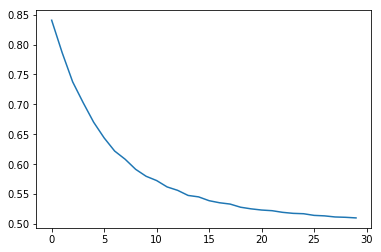

In [43]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.net = nn.Sequential(
            nn.BatchNorm1d(31),
            nn.Dropout(0.9),
            nn.Linear(31, 7),
            nn.Sigmoid(),
            nn.BatchNorm1d(7),
            nn.Dropout(0.9),
            nn.Linear(7, 2)
            #nn.Sigmoid(),
        )
        '''
        self.net = nn.Sequential(
            nn.Linear(31, 20),
            nn.ReLU(),
            nn.Linear(20, 15),
            nn.ReLU(),
            nn.Linear(15,2),
        )
        '''
    def forward(self, x):
        return self.net(x)

costs = []
def train(model, loss_fn, optimizer, num_epochs=1):
    model.train()
    for epoch in range(num_epochs):
        cost = 0.0
        for t, (x, y) in enumerate(loader_train):
            x_var = x.type(dtype)
            y_var = y.type(dtype)

            scores = model(x_var)

            loss = loss_fn(scores, y_var.long())
            cost += loss.data[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        costs.append(cost / (t + 1))
        if (epoch + 1) % (num_epochs / 10) == 0:
            print('Epoch = %d, loss = %.4f' % (epoch + 1, costs[-1]))

model = None
model = Model()
model.type(dtype)

lossfn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=0.01)


train(model, lossfn, optimizer, num_epochs=30)
plt.plot(costs)
plt.show()

In [44]:
import numpy as np

model.eval()

true = torch.Tensor([])
pred = torch.Tensor([])
for t, (x, y) in enumerate(loader_train):
    scores = model(x)
    scores_1 = scores[:,1].exp()
    scores_sum = scores.exp().sum(dim=1)
    scores = torch.div(scores_1,scores_sum)
    #a = np.zeros(true_numpy.size(),1)
    #b = np.ones(true_numpy.size(),1)
    #ab = np.hstack()
    true = torch.cat((true, y),0)
    pred = torch.cat((pred, scores),0)

true = true.detach().numpy()
pred = pred.detach().numpy()

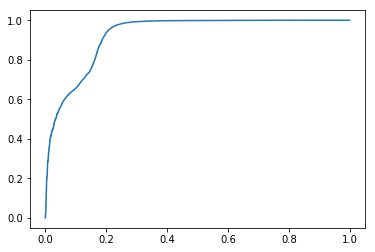

0.9260810449665691

In [45]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(true, pred)

plt.plot(fpr, tpr)
plt.show()
metrics.auc(fpr, tpr)

In [46]:
import pandas as pd
data_csv = pd.read_csv("Data/truth_test.csv", usecols=[1])
data_csv = data_csv.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')

test_label = dataset.reshape(-1).tolist()


In [47]:
class testing(Dataset):
    def __init__(self):
        self.len = len(test_feature)
        self.x_data = torch.Tensor(test_feature)
        self.y_data = torch.Tensor(test_label)
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len
    
test = testing()
loader_test = DataLoader(test, batch_size=batch_size, shuffle=False)

In [48]:
import numpy as np

model.eval()

true = torch.Tensor([])
pred = torch.Tensor([])
for t, (x, y) in enumerate(loader_test):
    scores = model(x)
    scores_1 = scores[:,1].exp()
    scores_sum = scores.exp().sum(dim=1)
    scores = torch.div(scores_1,scores_sum)
    #a = np.zeros(true_numpy.size(),1)
    #b = np.ones(true_numpy.size(),1)
    #ab = np.hstack()
    true = torch.cat((true, y),0)
    pred = torch.cat((pred, scores),0)

true = true.detach().numpy()
pred = pred.detach().numpy()

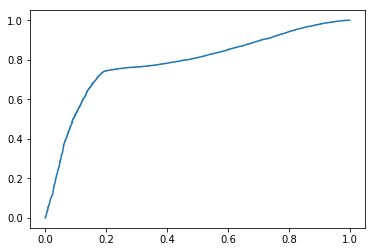

0.7837050991239258

In [49]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(true, pred)

plt.plot(fpr, tpr)
plt.show()
metrics.auc(fpr, tpr)